# The two-dimensional Ising model

- The Hamiltonian of the Ising model is

  \begin{equation*}
    \mathcal{H} = -J \sum_{\langle i, j \rangle} \sigma_i \, \sigma_j
  \end{equation*}
  
  where $\sigma_i = \pm 1$ is a spin living on the site $i$ of a periodic square
  lattice with $N = L \times L$ sites. We will consider a ferromagnetic coupling
  and set our unit of energy $J=1$.


- We will be interested in computing the energy and the magnetization at a given
  temperature $T = 1/\beta$
  
  \begin{equation*}
    \langle \mathcal{O} \rangle = \frac{1}{Z} \sum_{\sigma} e^{-\beta E(\sigma)} \, \mathcal{O}(\sigma)
    \qquad \text{where} \quad \mathcal{O} = E, m
  \end{equation*}
  
- The sum is over all spin configurations $\sigma = \{\sigma_1, \ldots, \sigma_N\}$. This is a total
  of $2^N$ terms which quickly becomes intractable.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(29387)
plt.style.use('style.mpl')

# A Monte Carlo approach

- We need to compute
  \begin{equation*}
    \langle \mathcal{O} \rangle = \frac{\sum_{\sigma} e^{-\beta E(\sigma)} \mathcal{O}(\sigma)}
    {\sum_{\sigma} e^{-\beta E(\sigma)}}
  \end{equation*}

- It seems very natural to try to compute these integrals using the Boltzmann probability

  \begin{equation*}
    \pi(\sigma) = \frac{e^{-\beta E(\sigma)}}{Z} \quad \to \quad
    \langle \mathcal{O} \rangle = \frac{\sum_{\sigma} \pi(\sigma) \, \mathcal{O}(\sigma) Z}
    {\sum_{\sigma} \pi(\sigma) \, Z}
    = \frac{\sum_{\sigma} \pi(\sigma) \, \mathcal{O}(\sigma)}
    {\sum_{\sigma} \pi(\sigma)} \simeq
    \frac{\sum_\sigma^\mathrm{MC} \mathcal{O}(\sigma)}{\sum_\sigma^\mathrm{MC} 1}
  \end{equation*}
  
- We got lucky: we do not know how to normalize the Boltzmann probability. But this normalization
  constant cancels in the fraction.
  
- $\sum^\mathrm{MC}_\sigma$ means a sum over samples $\sigma$ distributed according to
  $\pi(\sigma)$. Because the distribution is the same in the numerator and denominator,
  we can compute both sums **from the same samples**.
  
- We can use Metropolis-Hastings to sample $\pi(\sigma)$.

# Metropolis-Hastings algorithm

- We have to choose our proposal probability $T(\sigma \to \sigma')$.

- A possible choice is to pick a random site $i$ and flip $\sigma_i$

  \begin{equation*}
  T(\sigma \to \sigma') = \begin{cases}
  1/N & \text{if $\sigma$ and $\sigma'$ differ by a single spin flip} \\
  0 & \text{otherwise}
  \end{cases}
  \end{equation*}
  
- Acceptance probability

  \begin{equation*}
    A(\sigma \to \sigma') =
    \min \left( 1, \frac{\pi(\sigma')}{\pi(\sigma)} \right) =
    \min \left( 1, \frac{e^{-\beta E(\sigma')}}{e^{-\beta E(\sigma)}} \right)
    = \min \left( 1, e^{-\beta \Delta E} \right)
  \end{equation*}
  
- Again only a ratio of $\pi$'s appears and $Z$ cancels out.
  
- We only need to compute $\Delta E$. Because the change is local, this calculation
  is quick.

# Implementation

&nbsp;
<center><img src="figures/monte_carlo_loop.png" width=700px/></center>

In [2]:
def initialize(L):
    σ = np.random.choice([-1,1], size=(L,L))
    return σ

def monte_carlo_step(σ, β):
    
    L = σ.shape[0]

    # try L^2 flips
    for i in range(L**2):
        
        k, l = np.random.randint(L, size=2) # pick a site   
        ΔE = 2 * σ[k,l] * (σ[(k+1)%L,l] + σ[(k-1)%L,l] + σ[k,(l+1)%L] + σ[k,(l-1)%L])

        # accept the flip
        if np.random.rand() < np.exp(-β * ΔE):
            σ[k,l] *= -1
            
    return σ

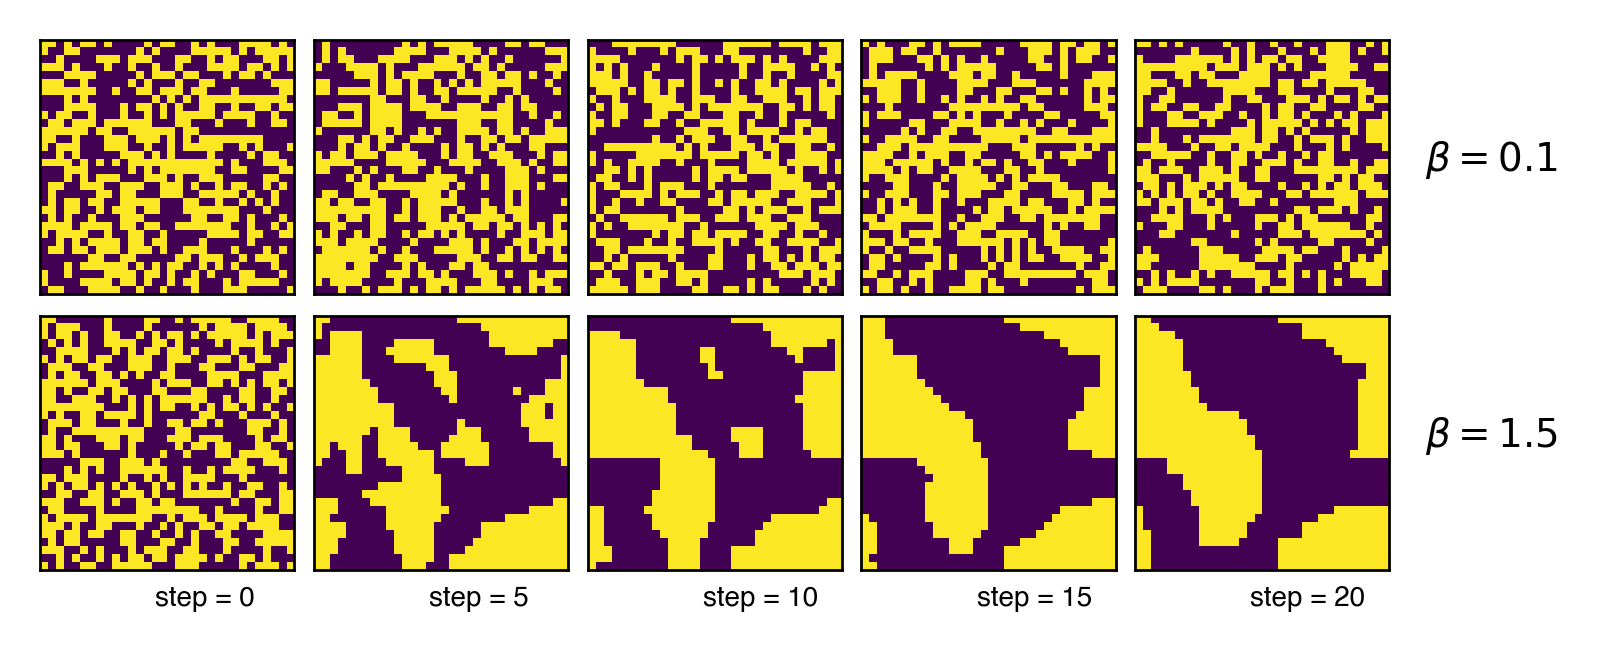

In [3]:
fig, ax = plt.subplots(2, 5, figsize=(8,4))
for i, β in enumerate([0.1, 1.5]):
    
    σ = initialize(32)
    for j in range(5):
        
        ax[i,j].matshow(σ)
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
        if i==1: ax[i,j].text(14, 36, f"step = {j*5}", fontsize=10)
        if j==4: ax[i,j].text(36, 16, fr'$\beta = {β}$')
            
        for k in range(5):
            monte_carlo_step(σ, β)
        
fig.tight_layout(h_pad=-2.5, w_pad=0.5)

# Computing observables

- We can compute the energy and the magnetization

In [4]:
def compute_energy(σ):
    L = σ.shape[0]
    E = 0
    for k in range(L):
        for l in range(L):
            E -= σ[k,l] * (σ[(k+1)%L,l] + σ[k,(l+1)%L])
    return E / L**2
            
def compute_magnetization(σ):
    L = σ.shape[0]
    return np.sum(σ) / L**2

In [5]:
# A single Monte Carlo run
n_samples = 2**10
energies = np.zeros(n_samples)
magnetizations = np.zeros(n_samples)

L = 8
T = 2.0
β = 1 / T
σ = initialize(L)

# MC simulation
for k in range(n_samples):
    
    monte_carlo_step(σ, β)
    energies[k] = compute_energy(σ)
    magnetizations[k] = compute_magnetization(σ)

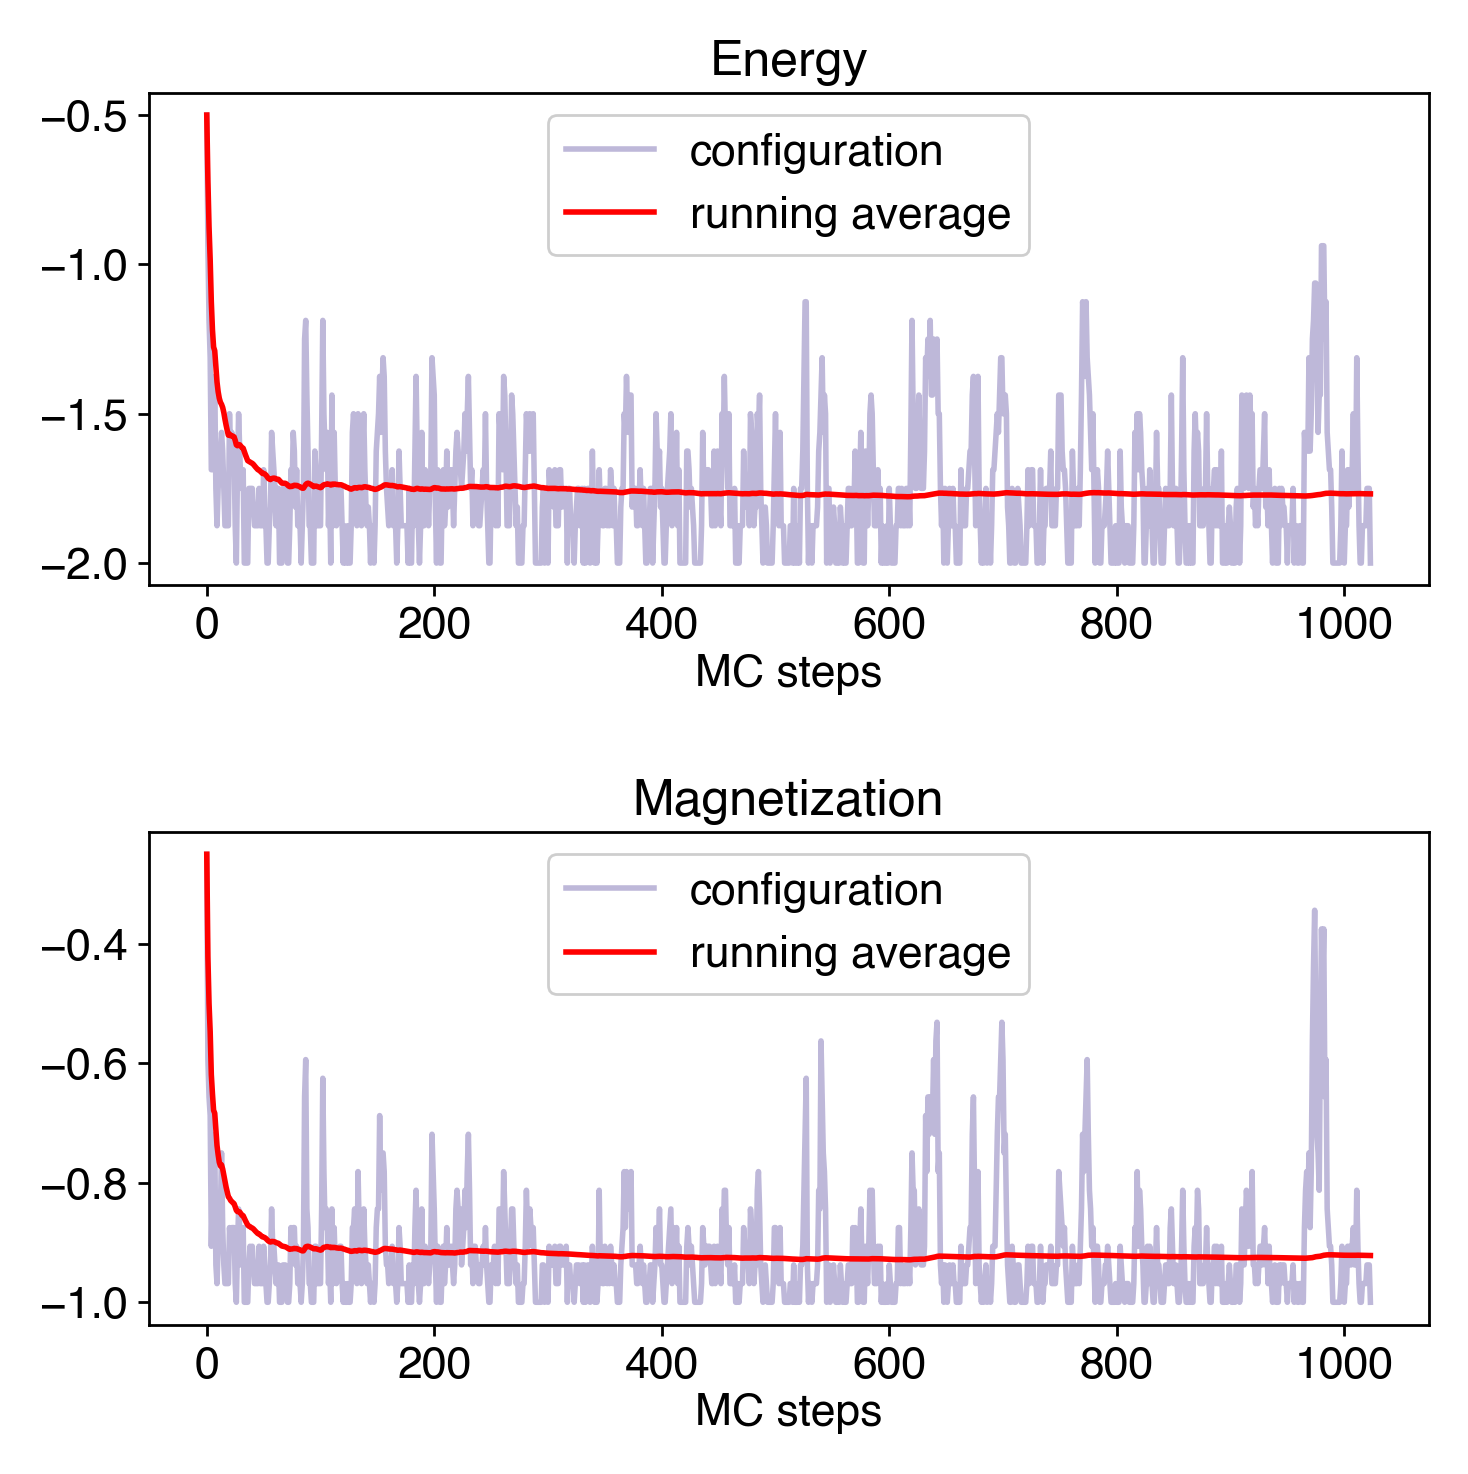

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))

ax[0].plot(energies, alpha=0.4, label="configuration")
ax[0].plot(np.cumsum(energies) / np.arange(1,n_samples+1), '-r', label="running average")
ax[0].set_title("Energy")
ax[0].set_xlabel("MC steps")
ax[0].legend(frameon=True, framealpha=0.95)

ax[1].plot(magnetizations, alpha=0.4, label="configuration")
ax[1].plot(np.cumsum(magnetizations) / np.arange(1,n_samples+1), '-r', label="running average")
ax[1].set_title("Magnetization")
ax[1].set_xlabel("MC steps")
ax[1].legend(frameon=True, framealpha=0.95)

plt.subplots_adjust(hspace=0.5)

In [7]:
# Compute several temperatures
Tr = np.linspace(1, 3, 10)[::-1]
n_T = Tr.size
L = 8
σ = initialize(L)

n_samples = 2**11
n_warmup = 200
energies = np.zeros([n_samples, n_T])
magnetizations = np.zeros([n_samples, n_T])

for i, T in enumerate(Tr):
    
    β = 1 / T
    for k in range(n_samples + n_warmup):

        # MC moves
        monte_carlo_step(σ, β)

        # measure after thermalization
        if k >= n_warmup:
            energies[k-n_warmup, i] = compute_energy(σ)
            magnetizations[k-n_warmup, i] = compute_magnetization(σ)

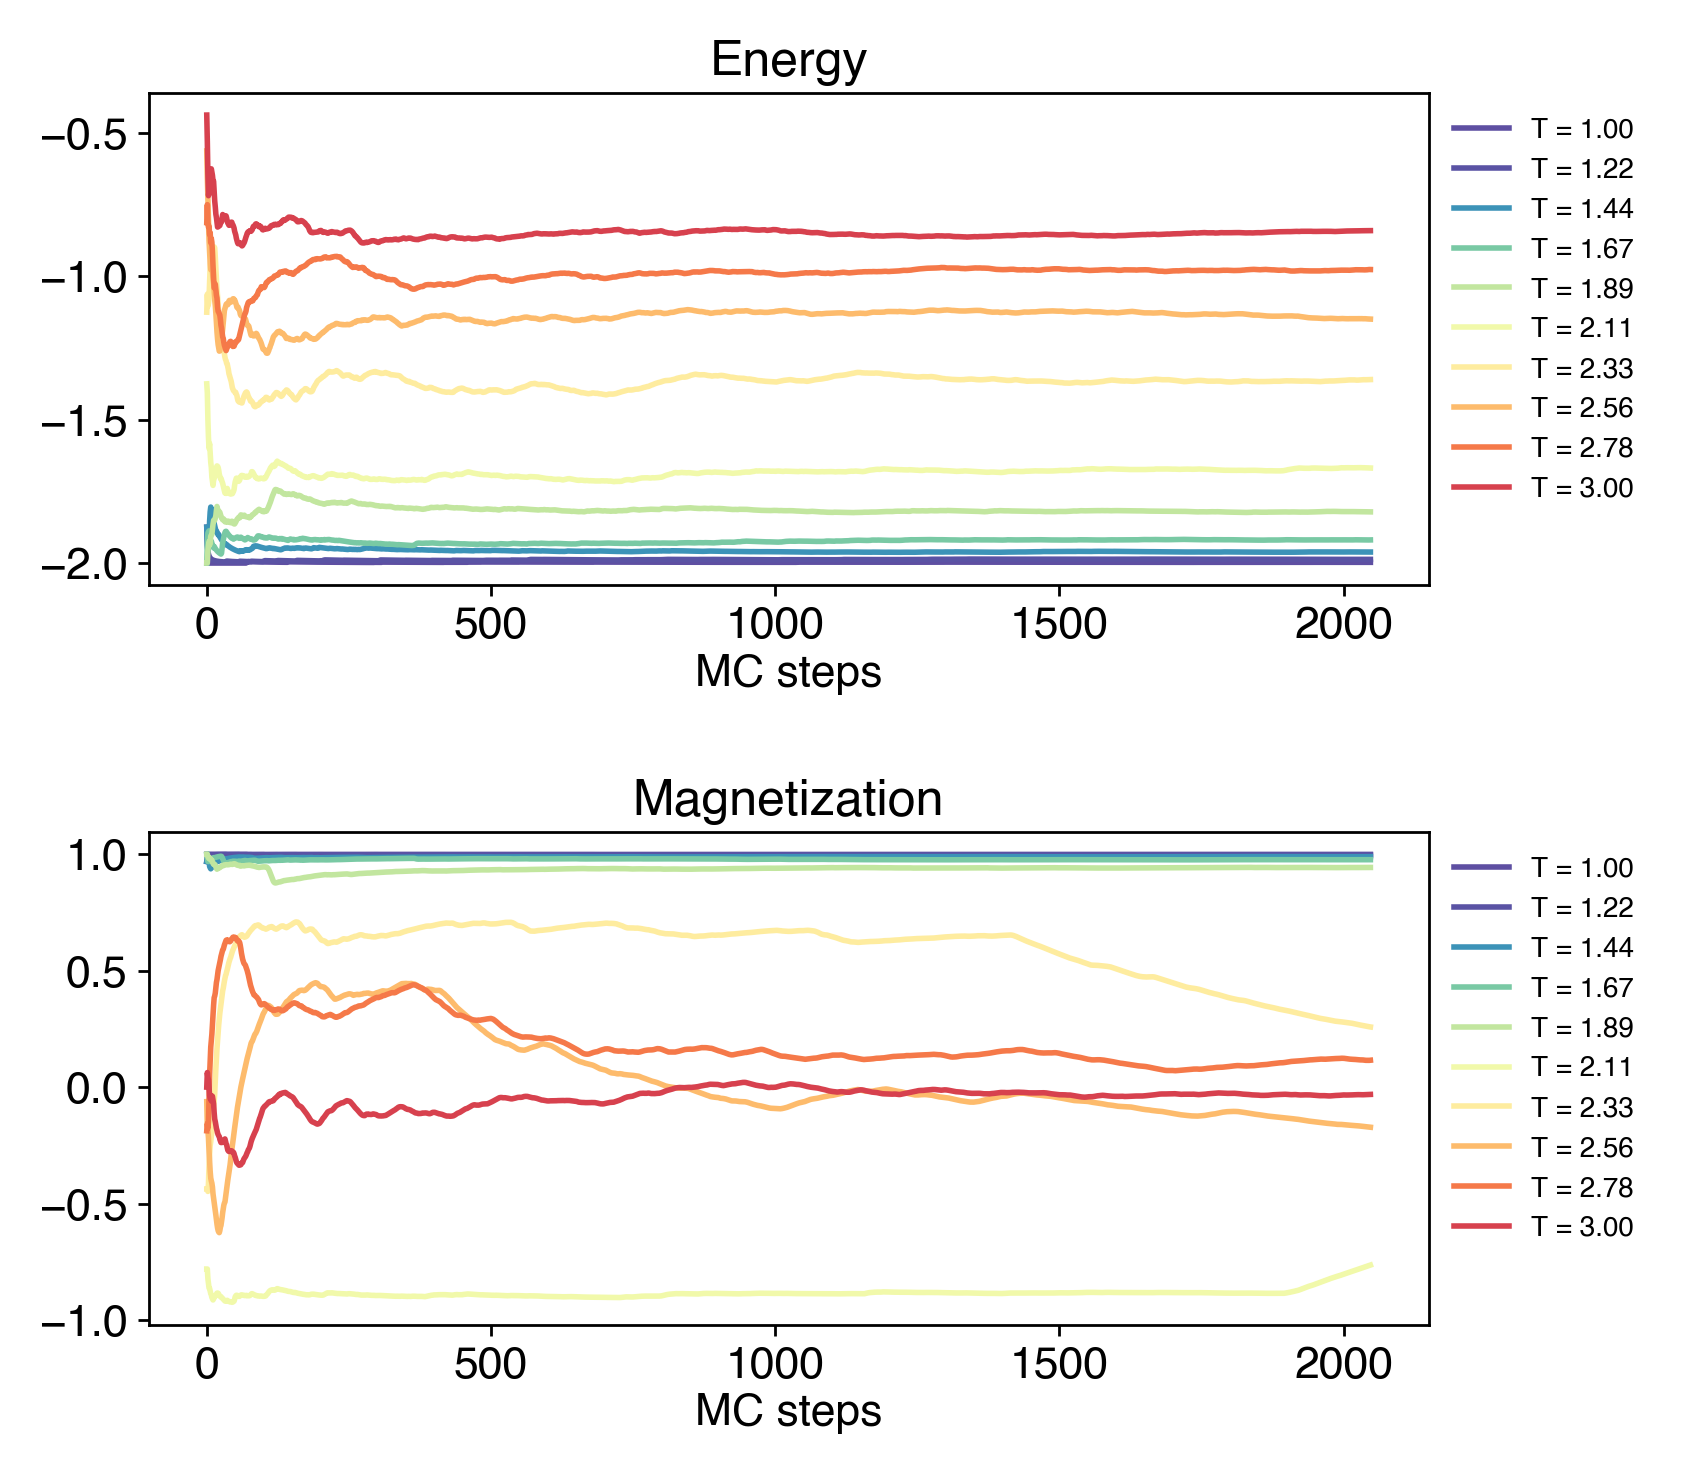

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))

for i, T in enumerate(Tr[::-1]):
    ax[0].plot(np.cumsum(energies[:,-i-1]) / np.arange(1,n_samples+1), '-', label=f"T = {T:.2f}")
ax[0].set_title("Energy")
ax[0].set_xlabel("MC steps")
ax[0].legend(fontsize=10, bbox_to_anchor=(1,1))

for i, T in enumerate(Tr[::-1]):
    ax[1].plot(np.cumsum(magnetizations[:,-i-1]) / np.arange(1,n_samples+1), '-', label=f"T = {T:.2f}")
ax[1].set_title("Magnetization")
ax[1].set_xlabel("MC steps")
ax[1].legend(fontsize=10, bbox_to_anchor=(1,1))

plt.subplots_adjust(hspace=0.5)

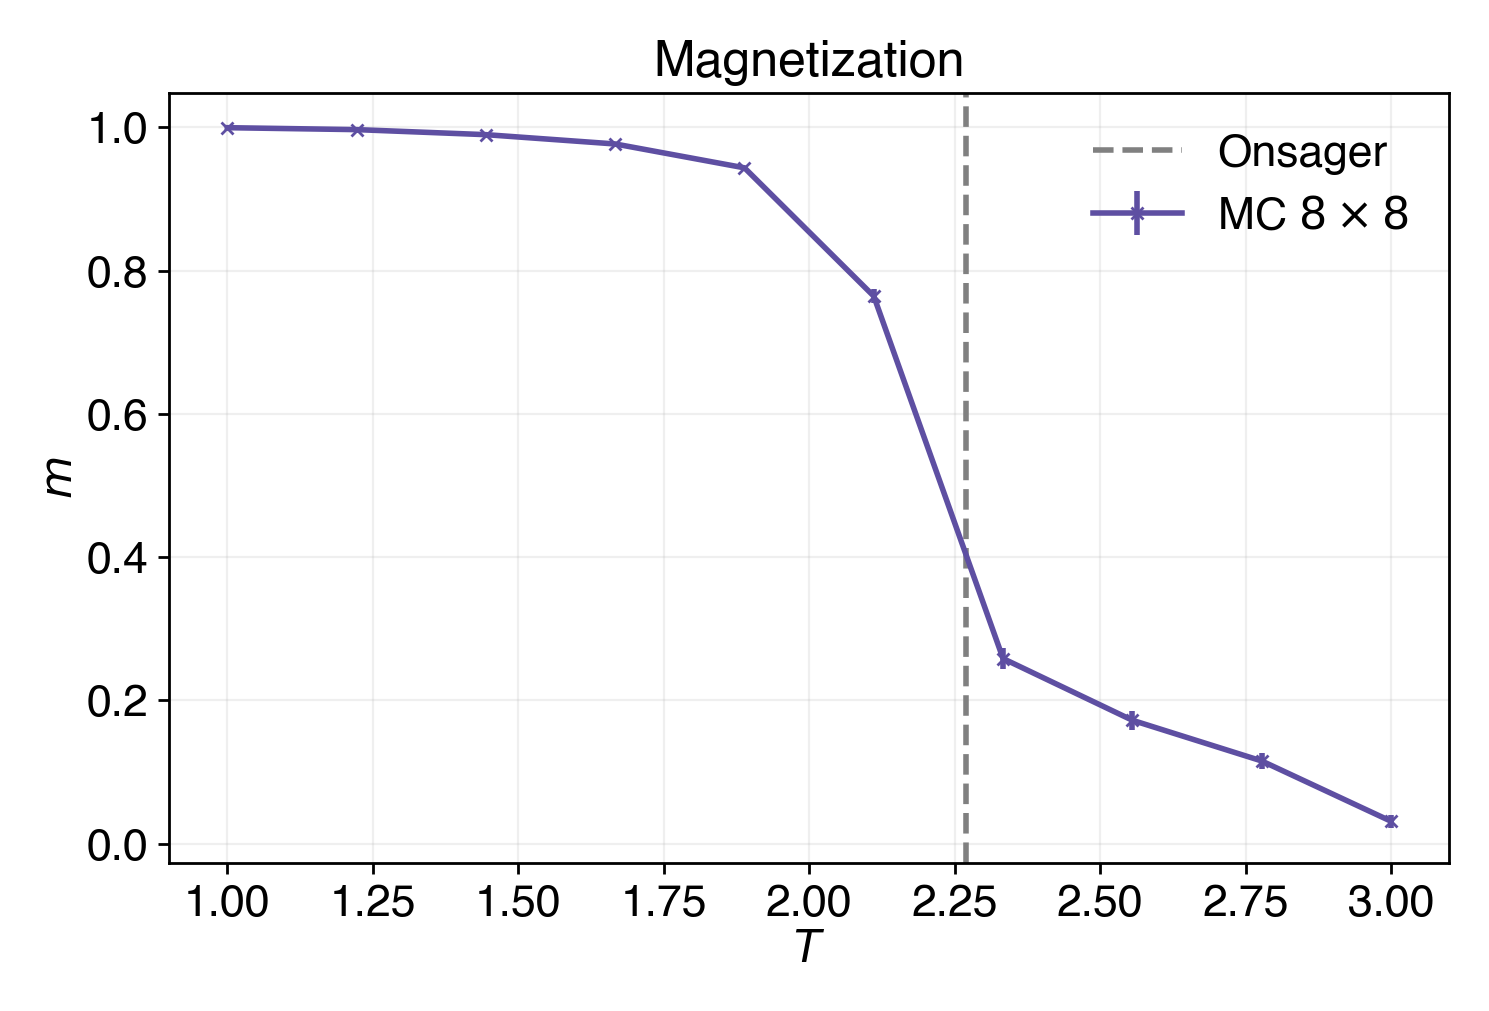

In [9]:
fig, ax = plt.subplots()

m = np.average(magnetizations, axis=0)
σₘ = np.std(magnetizations, axis=0) / np.sqrt(n_samples) # Danger!

ax.errorbar(Tr, np.abs(m), yerr=σₘ, marker='x', markersize=4, label=f"MC ${L} \\times {L}$")
ax.axvline(2.0/np.log(1.0+np.sqrt(2.0)), color='gray', linestyle='--', label="Onsager")
ax.set_title("Magnetization")
ax.set_xlabel("$T$")
ax.set_ylabel("$m$")
ax.grid(alpha=0.2)
ax.legend();

# Summary

- We have successfully used the Metropolis-Hastings algorithm to simulate the
  two-dimensional Ising model.
    
- The local update of a spin is fast but generates long correlation length.

- This leads to wrong estimates of the error bars with the naive formula.

- We will see how to compute error bars and good estimators.

- Note that there are many other efficient MCMC algorithms for the Ising model,
  e.g. cluster algorithms.

# Outline
    
- [Introduction to Monte Carlo](01-intro_monte_carlo.slides.html)

- [Newton–Cotes quadrature](02-newton_cotes.slides.html)
  
- [Importance sampling](03-importance_sampling.slides.html)

- [Direct sampling methods](04-direct_sampling.slides.html)

- [Markov chain sampling and balance condition](05-markov_chain.slides.html)

- [Metropolis-Hastings algorithm](06-metropolis_hastings.slides.html)

- [The two-dimensional Ising model](07-ising.slides.html)

- [Error bar analysis](08-error_analysis.slides.html)
  
- [References](09-references.slides.html)